In [1]:
%%capture
!pip install open3d
!pip install SimpleITK
!pip install scipy
!pip install bpy
!pip install numpy pillow
!pip install opencv-python

In [1]:
%%capture
try:
  import open3d as o3d
except ImportError:
  !pip install open3d
  import open3d as o3d
try:
  import SimpleITK as sitk
except ImportError:
  !pip install SimpleITK
  import SimpleITK as sitk
try:
  import bpy
except ImportError:
  !pip install bpy == 4.1.0
  import bpy
try:
  from stl import mesh
except ImportError:
  !pip install numpy-stl
  from stl import mesh
try:
  import pyvista as pv
except ImportError:
  !pip install pyvista
  import pyvista as pv
try:
  from scipy import ndimage
except ImportError:
  !pip install scipy
  from scipy import ndimage
try:
  from skimage import measure
except ImportError:
  !pip install scikit-image
  from skimage import measure
try:
  from google.colab import files
  IN_COLAB = True
except ImportError:
  IN_COLAB = False
try:
  import trimesh as t
  from trimesh.voxel import creation
except ImportError:
  !pip install trimesh
  import trimesh as t
  from trimesh.voxel import creation
try:
  from pygltflib import GLTF2, Animation, AnimationSampler
except ImportError:
  !pip install pygltflib
  from pygltflib import GLTF2, Animation, AnimationSampler
import numpy as np
import os
import math
import bmesh
from mathutils import Vector
import ipywidgets as widgets
from IPython.display import display
import subprocess
import matplotlib.pyplot as plt

In [2]:
import os
import bpy
import math
import numpy as np
from PIL import Image, ImageDraw
import open3d as o3d
import SimpleITK as sitk
from scipy import ndimage
import cv2

In [3]:
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
#@title #File Entry { display-mode: "form"}
#@markdown User can choose to upload the file to colab directly or select the google file upload button at the bottom of this form. Also choose the number of elements.

button_pressed = False  # Initialize the variable as False
filename = ""
button = widgets.Button(description="Google upload dialog")
output = widgets.Output()

def on_button_clicked(b):
    global button_pressed  # Access the global variable
    global filename
    with output:
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        button_pressed = True  # Set the variable to True when the button is clicked

button.on_click(on_button_clicked)
display(button, output)

ModuleNotFoundError: No module named 'google.colab'

In [3]:
#@title #File Entry { display-mode: "form"}

button_pressed = False  # Initialize the variable as False
filename = ""
button = widgets.Button(description="Google upload dialog")
output = widgets.Output()

def on_button_clicked(b):
    global button_pressed  # Access the global variable
    global filename
    with output:
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        button_pressed = True  # Set the variable to True when the button is clicked

if IN_COLAB:
  button.on_click(on_button_clicked)
  display(button, output)

In [4]:
#@title #Element Count { display-mode: "form", run: "auto" }
if not button_pressed:
    filename = "C:/Users/ZHEN/Downloads/angle_test/Balance_Shaft_Housing_Full_Shot parts - 8M0111257.stl" #@param {type:"string"}
element_count = 500 #@param {type:"slider", min:10, max:500, step:1}
geometry = o3d.io.read_triangle_mesh(os.path.join(os.getcwd(),filename))
max_boundary_size = (geometry.get_max_bound()-geometry.get_min_bound()).max()
mid_boundary_size = np.median(geometry.get_max_bound() - geometry.get_min_bound())
voxel_size = 1.5#max_boundary_size/element_count
print("Element size is in units from stl file ",voxel_size, " per cell")
origin = geometry.get_min_bound()

Element size is in units from stl file  1.5  per cell


In [5]:
rotation_angle = 90
Mu = 0.6
unit = 0.001

In [14]:
obj_file_path = 'C:/Users/ZHEN/Downloads/angle_test/remeshed_uv.obj'
blender_file_path = 'C:/Users/ZHEN/Downloads/angle_test/meshed_geometry.blend'
cosine_map_path = 'C:/Users/ZHEN/Downloads/angle_test/cosine_map.png'
angle_map_path = 'C:/Users/ZHEN/Downloads/angle_test/angle_map.png'
ejection_coefficient_map_path = 'C:/Users/ZHEN/Downloads/angle_test/ejection_coefficient_map.png'
parting_line_map_path = 'C:/Users/ZHEN/Downloads/angle_test/parting_line_map.png'
ejection_coefficient_mark_map_path = 'C:/Users/ZHEN/Downloads/angle_test/ejection_coefficient_mark_map.png'
cosine_result_path = 'C:/Users/ZHEN/Downloads/angle_test/colored_cosine.glb'
angle_result_path = 'C:/Users/ZHEN/Downloads/angle_test/colored_angle.glb'
ejection_coefficient_result_path = 'C:/Users/ZHEN/Downloads/angle_test/colored_ejection_coefficient.glb'
parting_line_result_path = 'C:/Users/ZHEN/Downloads/angle_test/colored_parting_line.glb'
ejection_coefficient_mark_result_path = 'C:/Users/ZHEN/Downloads/angle_test/colored_ejection_coefficient_mark.glb'

# Remesh and output OBJ file

In [7]:
bpy.ops.wm.read_factory_settings(use_empty=True)
bpy.ops.import_mesh.stl(filepath= filename, global_scale = unit)
bpy.ops.object.modifier_add(type='REMESH')
bpy.context.object.modifiers["Remesh"].mode = 'VOXEL'
bpy.context.object.modifiers["Remesh"].voxel_size = voxel_size * unit
bpy.ops.object.modifier_apply(modifier="Remesh")
bpy.ops.object.mode_set(mode='EDIT')
bpy.ops.mesh.select_all(action='SELECT')
bpy.ops.uv.smart_project()
bpy.ops.object.mode_set(mode='OBJECT')
selected_object = bpy.context.object
for obj in bpy.context.selected_objects:
    if obj.type == "MESH":
        bpy.ops.wm.obj_export(filepath= obj_file_path, export_triangulated_mesh=False, export_materials=False)
bpy.ops.wm.save_as_mainfile(filepath = blender_file_path)

Import finished in 5.1875 sec.
Info: Saved "meshed_geometry.blend"


{'FINISHED'}

# Process OBJ file

In [8]:
def process_obj(obj_file_path):
    vertices, faces, vt_coordinates, vt_faces = [], [], [], []
    with open(obj_file_path, 'r') as obj_file:
        for line in obj_file:
            parts = line.split()
            if parts[0] == 'v':
                vertices.append(list(map(float, parts[1:4])))
            elif parts[0] == 'f':
                f, vt_f = zip(*((int(x.split('/')[0]) - 1, int(x.split('/')[1]) - 1) for x in parts[1:]))
                faces.append(f), vt_faces.append(vt_f)
            elif parts[0] == 'vt':
                vt_coordinates.append(list(map(float, parts[1:])))
    return vertices, faces, vt_coordinates, vt_faces

In [11]:
vertices, faces, vt_coordinates, vt_faces = process_obj(obj_file_path)

# Ejection coefficient calculation

In [9]:
def ejection_coefficient_calculation(selected_axis_data, vertices, faces, Mu, unit):
    direction, num_eject_faces = np.array(selected_axis_data), 0
    angle_list, cosine_list, a_list, Phi_list = [], [], [], []
    for face in faces:
        normal = np.cross(*(np.array(vertices[face[i]]) - np.array(vertices[face[0]]) for i in (1, 2)))
        cosine = np.dot(normal / np.linalg.norm(normal), direction / np.linalg.norm(direction))
        cosine_list.append(cosine)
        theta = np.arccos(cosine)
        angle_list.append(theta)
        a = Mu * np.sqrt(1 - cosine**2) - abs(cosine)
        # num_eject_faces += (0 <= a <= Mu)
        num_eject_faces += (- np.sqrt(Mu**2 + 1) <= a <= np.sqrt(Mu**2 + 1))
        a_list.append(a)
    Phi_list = [num_eject_faces * (unit**2) * a for a in a_list]
    return angle_list, cosine_list, Phi_list, max((Phi for Phi in Phi_list), default=None)

#Optimize ejection direction


In [12]:
def ejection_force_rotation(rotation_angle):
    def rotation_matrix(axis, theta):
        theta = np.radians(theta)
        if axis == 'x':
            return np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
        elif axis == 'y':
            return np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
        elif axis == 'z':
            return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    unique_rotations = {}
    for theta_x in range(0, 360 + rotation_angle, rotation_angle):
        for theta_y in range(0, 360 + rotation_angle, rotation_angle):
            for theta_z in range(0, 360 + rotation_angle, rotation_angle):
                rotated_vector = np.dot(rotation_matrix('x', theta_x),
                                        np.dot(rotation_matrix('y', theta_y),
                                               np.dot(rotation_matrix('z', theta_z), np.array([0, 1, 0]))))
                rotated_vector = tuple(np.where(np.abs(rotated_vector) < 0.001, 0, rotated_vector))
                unique_rotations.setdefault(rotated_vector, (theta_x, theta_y, theta_z))
    unique_angles_list = list(unique_rotations.values())
    unique_vectors_list = [list(vec) for vec in unique_rotations.keys()]
    return unique_angles_list, unique_vectors_list

In [17]:
directions = ejection_force_rotation(rotation_angle)[1]
rotation_max_Phi = [ejection_coefficient_calculation(direction, vertices, faces, Mu, unit)[-1] for direction in directions]
#print(directions)
#print(rotation_max_Phi)

C:\Users\ZHEN\AppData\Local\Temp\ipykernel_40644\3993966985.py:6: RuntimeWarning: invalid value encountered in divide
  cosine = np.dot(normal / np.linalg.norm(normal), direction / np.linalg.norm(direction))


# Identified undercut

In [27]:
pcd = geometry.sample_points_uniformly(number_of_points=100000000)
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size = voxel_size)
voxels = voxel_grid.get_voxels()
indices = np.stack(list(vx.grid_index for vx in voxels))
del voxels, voxel_grid, pcd
max_indices = np.max(indices, axis=0)+1
dense_array = np.zeros(max_indices, dtype=np.bool_)
for idx in indices:
    dense_array[tuple(idx)] = 1
del indices
array_pad = np.pad(dense_array.astype(bool),((2,2)),'constant')
del dense_array
array_closing = ndimage.binary_closing(array_pad, structure=ndimage.generate_binary_structure(3, 1),
iterations=1, mask=None,  border_value=0, origin=0, brute_force=False)
img = sitk.GetImageFromArray(array_closing.astype(int))
seg = sitk.ConnectedComponent(img != img[0,0,0])
img_filled = sitk.BinaryFillhole(seg!=0)
array_filled = sitk.GetArrayFromImage(img_filled)

In [8]:
def find_undercut(array, direction):
    direction = np.round(direction / np.max(np.abs(direction))).astype(int)
    one_indices = np.argwhere(array == 1)
    visited = set()
    for start in one_indices:
        pos = tuple(start)
        if pos in visited:
            continue
        found_zero = False
        while all(0 <= pos[i] < array.shape[i] for i in range(3)):
            if pos in visited:
                break
            visited.add(pos)
            if array[pos] == 1:
                if found_zero:
                    return 1
            elif array[pos] == 0:
                found_zero = True
            pos = tuple(np.array(pos) + direction)
    return 0

In [28]:
geometry_array = array_filled
adjusted_directions = [[round(d[0], 3), round(d[2], 3), round(d[1], 3)] for d in directions]
undercut_results = [find_undercut(geometry_array, np.array(d)) for d in adjusted_directions]
direction_mapping = {tuple(d): i for i, d in enumerate(adjusted_directions)}
for i, direction in enumerate(adjusted_directions):
    opposite_direction = tuple(-np.array(direction))
    if tuple(direction) in direction_mapping and opposite_direction in direction_mapping:
        opp_index = direction_mapping[opposite_direction]
        if undercut_results[i] == 1 or undercut_results[opp_index] == 1:
            undercut_results[i] = 1
            undercut_results[opp_index] = 1
print(undercut_results)

[0, 1, 0, 1, 1, 1]


# Ejection direction

In [19]:
min_Phi, ejection_direction = min(
    (rotation_max_Phi[i], directions[i])
    for i, val in enumerate(undercut_results) if val == 0)
Phi_list_optimize, max_Phi_optimize = ejection_coefficient_calculation(ejection_direction, vertices, faces, Mu, unit)
print(ejection_direction)
print(max_Phi_optimize)

NameError: name 'undercut_results' is not defined

In [12]:
ejection_direction = [0.0, 1.0, 0.0]
angle_list, cosine_list, Phi_list_optimize, max_Phi_optimize = ejection_coefficient_calculation(ejection_direction, vertices, faces, Mu, unit)
print(ejection_direction)
print(max_Phi_optimize)

[0.0, 1.0, 0.0]
0.030062399999999996


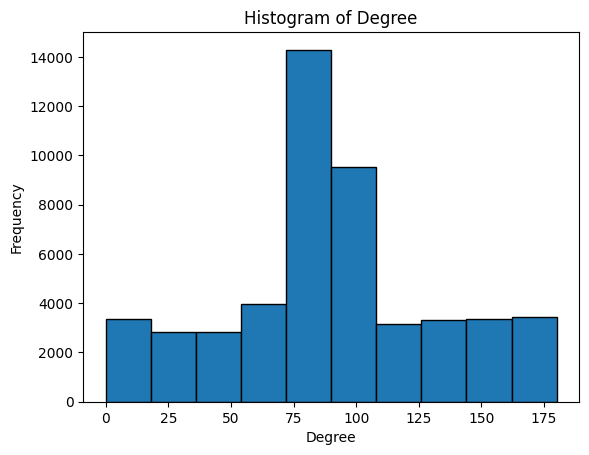

In [13]:
degree_list = [np.degrees(x) for x in angle_list]
plt.hist(degree_list, bins=10, edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Degree')
plt.show()


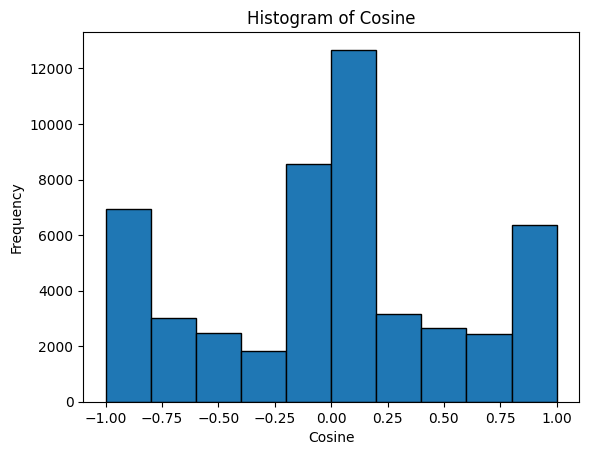

In [28]:
plt.hist(cosine_list, bins=10, edgecolor='black')
plt.xlabel('Cosine')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine')
plt.show()

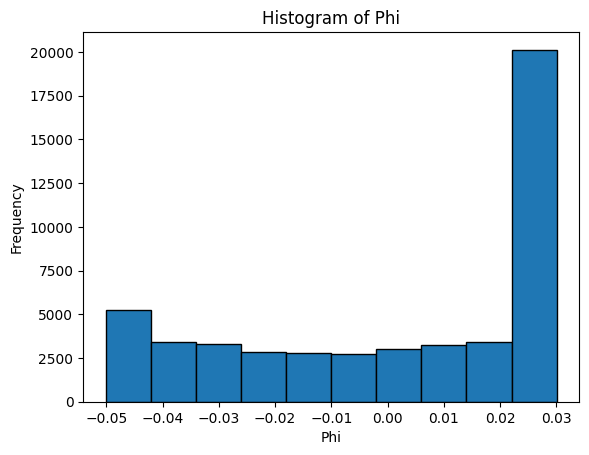

In [29]:
plt.hist(Phi_list_optimize, bins=10, edgecolor='black')
plt.xlabel('Phi')
plt.ylabel('Frequency')
plt.title('Histogram of Phi')
plt.show()

# Angle

In [ ]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, theta in zip(vt_faces, angle_list):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if 0 <= theta / np.pi <= 1:
            color = color_bins[min(int((theta / np.pi) * 10), 9)]
        else:
            color = (120, 120, 120)
        draw.polygon(vt_indices, outline=color, fill=color)
image.save(angle_map_path)

In [ ]:
bpy.ops.wm.open_mainfile(filepath = blender_file_path)
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load(angle_map_path)
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = angle_result_path)

# Cosine

In [ ]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, cos in zip(vt_faces, cosine_list):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if -1 <= cos <= 1:
            color = color_bins[min(int((abs(cos)) * 10), 9)]
        else:
            color = (120, 120, 120)
        draw.polygon(vt_indices, outline=color, fill=color)
image.save(cosine_map_path)

In [ ]:
bpy.ops.wm.open_mainfile(filepath = blender_file_path)
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load(cosine_map_path)
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = cosine_result_path)

# Ejection coefficient map

In [142]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, Phi in zip(vt_faces, Phi_list_optimize):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if 0 <= Phi <= max_Phi_optimize:
            color = color_bins[min(int((Phi / max_Phi_optimize) * 10), 9)]
        elif Phi < 0:
            color = (120, 120, 120)
        else:
            color = (0, 0, 0)
        draw.polygon(vt_indices, outline=color, fill=color)
image.save(ejection_coefficient_map_path)

# Ejection Coefficient larger value mark map

In [ ]:
image_size = 4000
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, Phi in zip(vt_faces, Phi_list_optimize):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        if max_Phi_optimize * 0.99 <= Phi <= max_Phi_optimize:
            color = (0, 256, 0)
        else:
            color = (0, 0, 0)
        draw.polygon(vt_indices, outline=color, fill=color)
image_pil = Image.open(ejection_coefficient_map_path).convert("RGB")
image_cv = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
green_mask = cv2.inRange(cv_image, (0, 255, 0), (0, 255, 0))
kernel = np.ones((3, 3), np.uint8)
dilated_mask = cv2.dilate(green_mask, kernel, iterations=10)
dilated_image = np.zeros_like(cv_image)
dilated_image[dilated_mask == 255] = (0, 255, 0) 
combined_image = image_cv.copy()
combined_image[dilated_mask == 255] = (0, 255, 0)
final_image_pil = Image.fromarray(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
final_image_pil.save(ejection_coefficient_mark_map_path)

In [29]:
bpy.ops.wm.open_mainfile(filepath = blender_file_path)
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load(ejection_coefficient_mark_map_path)
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = ejection_coefficient_mark_result_path)

04:03:15 | ERROR: Draco mesh compression is not available because library could not be found at c:\Users\ZHEN\Downloads\4.1\python\lib\site-packages\extern_draco.dll
04:03:15 | INFO: Starting glTF 2.0 export
04:03:15 | INFO: Extracting primitive: Balance_Shaft_Housing_Full_Shot parts - 8M0111257
04:03:15 | INFO: Primitives created: 1
04:03:15 | INFO: Finished glTF 2.0 export in 0.1966402530670166 s



{'FINISHED'}

# parting line identified

In [15]:
image_size = 4000
color_bins = [(i, 0, 256 - i) for i in range(0, 256, 26)]
image = Image.new("RGB", (image_size, image_size), "black")
draw = ImageDraw.Draw(image)
scaled_vt_coordinates = [
    (vt[0] * image_size, (1 - vt[1]) * image_size) for vt in vt_coordinates]
for vt_face, cos in zip(vt_faces, cosine_list):
    if all(0 <= j < len(scaled_vt_coordinates) for j in vt_face):
        vt_indices = [scaled_vt_coordinates[j] for j in vt_face]
        color = (256, 256, 256) if cos > 0 else (256, 0, 0)
        draw.polygon(vt_indices, outline=color, fill=color)
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
red_mask = cv2.inRange(image, np.array([0, 0, 255]), np.array([0, 0, 255]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
kernel = np.ones((3, 3), np.uint8)
red_mask_cleaned_close = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel,iterations=1)
red_mask_cleaned_open = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel,iterations=1)
white_mask_cleaned_close = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel,iterations=1)
white_mask_cleaned_open = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel,iterations=1)
white_dilated = cv2.dilate(white_mask_cleaned_close + white_mask_cleaned_open - white_mask, kernel, iterations=1)
boundary_mask = cv2.bitwise_and(red_mask_cleaned_close + red_mask_cleaned_open - red_mask, white_dilated)
boundary_mask_cleaned_open = cv2.morphologyEx(boundary_mask, cv2.MORPH_OPEN, kernel,iterations=1)
boundary_mask_cleaned_close = cv2.morphologyEx(boundary_mask, cv2.MORPH_CLOSE, kernel,iterations=1)
output_image = np.zeros_like(image)
contours, _ = cv2.findContours(boundary_mask_cleaned_close - boundary_mask_cleaned_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(output_image, contours, -1, [0, 255, 0], thickness=2)
cv2.imwrite(parting_line_map_path, cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

True

# Visualization

## Ejection coefficient result

In [143]:
bpy.ops.wm.open_mainfile(filepath = blender_file_path)
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load(ejection_coefficient_map_path)
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = ejection_coefficient_result_path)

01:36:39 | ERROR: Draco mesh compression is not available because library could not be found at c:\Users\ZHEN\Downloads\angle_test\4.1\python\lib\site-packages\extern_draco.dll
01:36:39 | INFO: Starting glTF 2.0 export
01:36:39 | INFO: Extracting primitive: Balance_Shaft_Housing_Full_Shot parts - 8M0111257
01:36:39 | INFO: Primitives created: 1
01:36:39 | INFO: Finished glTF 2.0 export in 0.19204330444335938 s



{'FINISHED'}

## parting line result

In [16]:
bpy.ops.wm.open_mainfile(filepath = blender_file_path)
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
bsdf = nodes.new('ShaderNodeBsdfPrincipled')
texture = nodes.new('ShaderNodeTexImage')
output = nodes.new('ShaderNodeOutputMaterial')
texture.location = (-200, 0)
output.location = (200, 0)
texture.image = bpy.data.images.load(parting_line_map_path)
links.new(texture.outputs['Color'], bsdf.inputs['Base Color'])
links.new(bsdf.outputs['BSDF'], output.inputs['Surface'])
bpy.context.object.data.materials.append(material)
bpy.ops.export_scene.gltf(filepath = parting_line_result_path)

02:00:56 | ERROR: Draco mesh compression is not available because library could not be found at c:\Users\ZHEN\Downloads\4.1\python\lib\site-packages\extern_draco.dll
02:00:56 | INFO: Starting glTF 2.0 export
02:00:56 | INFO: Extracting primitive: Balance_Shaft_Housing_Full_Shot parts - 8M0111257
02:00:56 | INFO: Primitives created: 1
02:00:56 | INFO: Finished glTF 2.0 export in 0.16922354698181152 s



{'FINISHED'}

# Clean

In [ ]:
files_to_delete = [
    "/content/meshed_geometry.blend",
    "/content/remeshed_uv.obj",]
for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)